<a href="https://colab.research.google.com/github/MehrigulKadir/Supply-Chain-Analysis-Big-Data-with-PySpark/blob/main/Supply_Chain_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%html
<div style="background-color:#FFD700; color: #ffffff; padding: 20px; border-radius: 10px; text-align: center;">
  <h2>Supply-Chain Exploratory Data Analysis</h2>
</div>


In [ ]:
%%html
<div style="background-color: #FFFFE0 ; color: #000000; padding: 20px; border-radius: 10px; text-align: left;">
  <h2>1. SetUp SparkSQL-Magic</h2>
</div>






In [ ]:
!pip install sparksql-magic
%load_ext sparksql_magic

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
spark



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=c6ab18fdea80db9fddb122e706641fd9d489eb3c1a17e8738d9b4938ef4d5068
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
%%html
<div style="background-color: #FFFFE0 ; color: #000000; padding: 20px; border-radius: 10px; text-align: left;">
  <h2>2. Load Data & Data Overview </h2>
</div>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = spark.read.csv('/content/drive/MyDrive/data_lake/SupplyChain.csv',header=True, sep=",", inferSchema=True)
df.show()

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+--------------+----------------+--------------+--------------+-----------+--------------+-----------------+----------------+--------------+--------------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+--------------------+---------------+-------------+---------------+-------------------+-------------------+--------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sale

In [ ]:
df.columns

['Type',
 'Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Sales per customer',
 'Delivery Status',
 'Late_delivery_risk',
 'Category Id',
 'Category Name',
 'Customer City',
 'Customer Country',
 'Customer Email',
 'Customer Fname',
 'Customer Id',
 'Customer Lname',
 'Customer Password',
 'Customer Segment',
 'Customer State',
 'Customer Street',
 'Customer Zipcode',
 'Department Id',
 'Department Name',
 'Latitude',
 'Longitude',
 'Market',
 'Order City',
 'Order Country',
 'Order Customer Id',
 'order date (DateOrders)',
 'Order Id',
 'Order Item Cardprod Id',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Id',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'Order Item Total',
 'Order Profit Per Order',
 'Order Region',
 'Order State',
 'Order Status',
 'Order Zipcode',
 'Product Card Id',
 'Product Category Id',
 'Product Description',
 'Product Image',
 'Product Name',
 'Product P

In [ ]:
df.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Email: string (nullable = true)
 |-- Customer Fname: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Lname: string (nullable = true)
 |-- Customer Password: string (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer State: string (nullable = true)
 |-- Customer Street: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = 

In [ ]:
%%html
<div style="background-color: #FFFFE0 ; color: #000000; padding: 20px; border-radius: 10px; text-align: left;">
  <h2> 3. Data Cleaning  </h2>
</div>

In [ ]:
from pyspark.sql.functions import col, sum

missing_counts = df.select([sum(col(c).isNull().cast('int')).alias(c) for c in df.columns])
missing_counts_dict = missing_counts.first().asDict()

# Check if there are any missing values
missing_values_exist = any(count > 0 for count in missing_counts_dict.values())

if not missing_values_exist:
    print("There are no missing values.")
else:
    print("There are missing values in the following columns:")
    for column, count in missing_counts_dict.items():
        if count > 0:
            print(f"{column}: {count} missing value(s)")


There are missing values in the following columns:
Customer Lname: 8 missing value(s)
Customer Zipcode: 3 missing value(s)
Order Zipcode: 155679 missing value(s)
Product Description: 180519 missing value(s)


### We have decided to drop the "Order Zip Code" and "Product Description" columns due to their significant number of missing values. The presence of other columns allows us to accurately identify the delivery address for orders, and "Product Description" is deemed irrelevant to our current analysis. For missing values in the "Customer Zipcode" column will be replaced with 0 for consistency in data handling. We also drop some columns due to data privacy issues and irrelevance for our further analysis.##


In [ ]:
from pyspark.sql.functions import when


# Dropping columns with a large amount of missing values and irrelevant columns for analysis
columns_to_drop = ['Order Zipcode', 'Product Description', 'Customer Email', 'Customer Fname', 'Customer Lname',
                   'Customer Password', 'Customer State', 'Customer Street', 'Product Image']
df_cleaned = df.drop(*columns_to_drop)

# Replace missing values in 'Customer Zipcode' with 0
df_cleaned = df_cleaned.withColumn('Customer Zipcode', when(df_cleaned['Customer Zipcode'].isNull(), 0).otherwise(df_cleaned['Customer Zipcode']))

# Show sample data after cleaning
df_cleaned.show(10)

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+---------------+-------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|  Delivery Status|Late_delivery_risk|Category Id| Category Name|Customer City|Customer Country|Customer Id|Customer Segment|Customer Zipcode|Depa

In [ ]:
# Group by all columns to find duplicates
duplicate_count = df_cleaned.groupBy(df_cleaned.columns).count().where('count > 1').count()

# Print message based on duplicate count
if duplicate_count == 0:
    print("There are no duplicate rows.")
else:
    print(f"There are {duplicate_count} duplicate rows.")

There are no duplicate rows.


In [ ]:
df_cleaned.printSchema()

root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Market: string (nullable = true)
 |-- Order City: string (nullable = true)
 |-- Order Country: string (nullable = true)
 |-- Order Customer I

In [ ]:
# Check for anomalies in 'Order State' column
df_cleaned.select('Order State').distinct().show()


+--------------------+
|         Order State|
+--------------------+
|                Hims|
|             Malanje|
|           Cajamarca|
|                Utah|
|          Luxemburgo|
|              Shumen|
|          Ul�n Bator|
|                Meca|
|                Lodz|
|             B�o-B�o|
|            Bruselas|
| Mato Grosso del Sur|
|                Ilam|
|Territorio de la ...|
|               Cear�|
|          Wellington|
|            Arequipa|
|                 Oyo|
|            Manitoba|
|            Estuaire|
+--------------------+
only showing top 20 rows



In [ ]:
# Count occurrences of problematic values
problematic_values_count = df_cleaned.filter(col('Order State').contains('�')).count()
print(f"Number of rows with encoding issue in 'Order State': {problematic_values_count}")

Number of rows with encoding issue in 'Order State': 35310


In [ ]:
from pyspark.sql.functions import col, when

df_cleaned = df_cleaned.withColumn('Order State', when(col('Order State').contains('�'), 'Rajasthan').otherwise(col('Order State')))

df_cleaned.show(10)

+--------+------------------------+-----------------------------+-----------------+------------------+-----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+---------------+-------------------+------------+-------------+--------------+--------------------------+--------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer|  Delivery Status|Late_delivery_risk|Category Id| Category Name|Customer City|Customer Country|Customer Id|Customer Segment|Customer Zipcode|Depa

In [ ]:
%%html
<div style="background-color: #FFFFE0 ; color: #000000; padding: 20px; border-radius: 10px; text-align: left;">
  <h2> 4. Sales Analysis  </h2>
</div>

In [ ]:
# Aggregate sales by product category
category_sales = df_cleaned.groupBy('Category Name').agg({'Sales': 'sum'}).withColumnRenamed('sum(Sales)', 'Total Sales')

# Display results
category_sales.show()


+--------------------+------------------+
|       Category Name|       Total Sales|
+--------------------+------------------+
|    Men's Golf Clubs| 47035.80051772003|
| Children's Clothing|232829.20397719863|
|      Sporting Goods|         117006.75|
|    Camping & Hiking| 4118425.571018961|
| Fitness Accessories|35601.440543579985|
|            Cameras | 267607.6850319988|
|          Golf Shoes|          107998.0|
|           Computers|          663000.0|
|Consumer Electronics| 108991.2821118995|
|          Basketball| 27099.32934339999|
|   Health and Beauty|106080.48307700001|
|        Pet Supplies|41524.800752760195|
|                DVDs| 79395.54236669955|
|      Men's Footwear| 2891757.662352659|
|              Crafts|223356.32532400126|
|    Women's Clothing|140283.00474499984|
|         Electronics| 371034.6431878932|
|         Video Games|           33310.5|
|     Women's Apparel|         3147800.0|
|      Girls' Apparel|    151706.2006334|
+--------------------+------------

<ipython-input-23-5b5c48fd2548>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total Sales', y='Category Name', data=top_category_sales, palette='viridis')


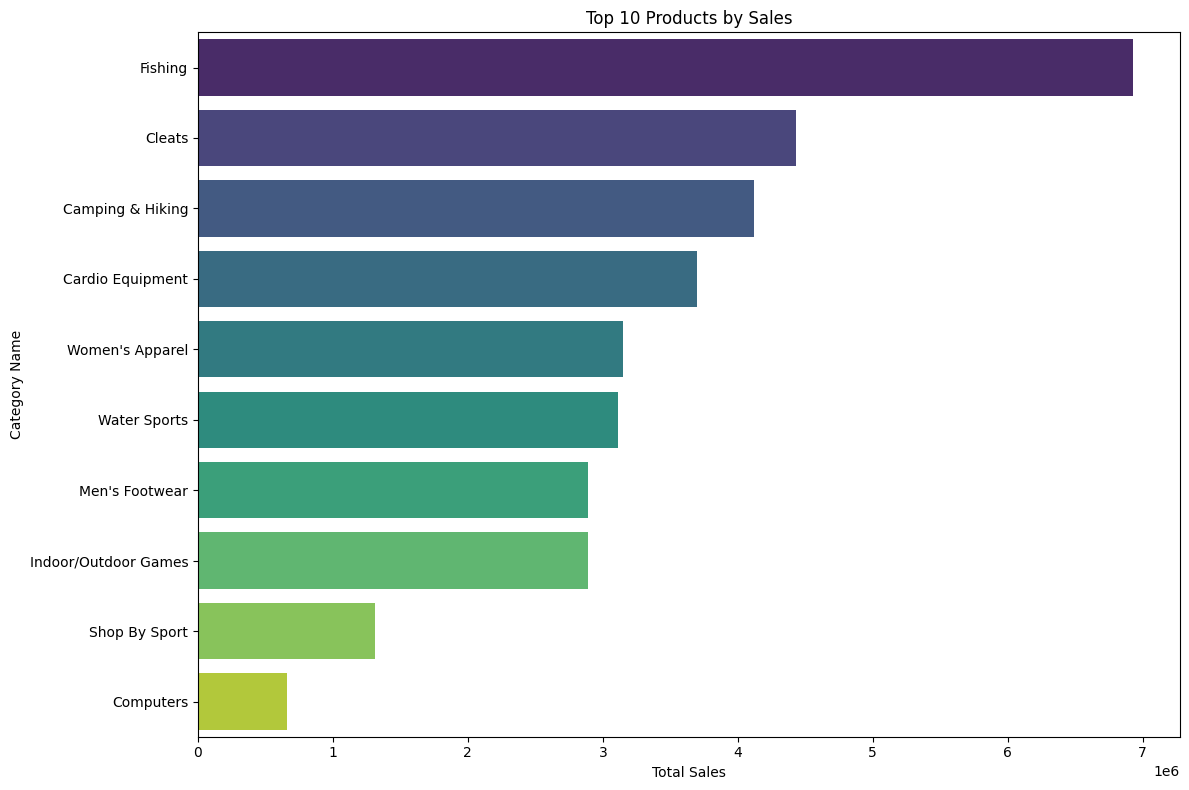

In [ ]:
# Collect data to local Python environment
category_sales_local = category_sales.toPandas()

# Sort by Total Sales in descending order
category_sales_local = category_sales_local.sort_values(by='Total Sales', ascending=False)

# Select top N products with highest sales
top_n = 10
top_category_sales = category_sales_local.head(top_n)

# Plot horizontal bar plot using Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns  # Optional: for using color palettes

plt.figure(figsize=(12, 8))

# Create horizontal bar plot
sns.barplot(x='Total Sales', y='Category Name', data=top_category_sales, palette='viridis')

plt.xlabel('Total Sales')
plt.ylabel('Category Name')
plt.title(f'Top {top_n} Products by Sales')

plt.tight_layout()
plt.show()

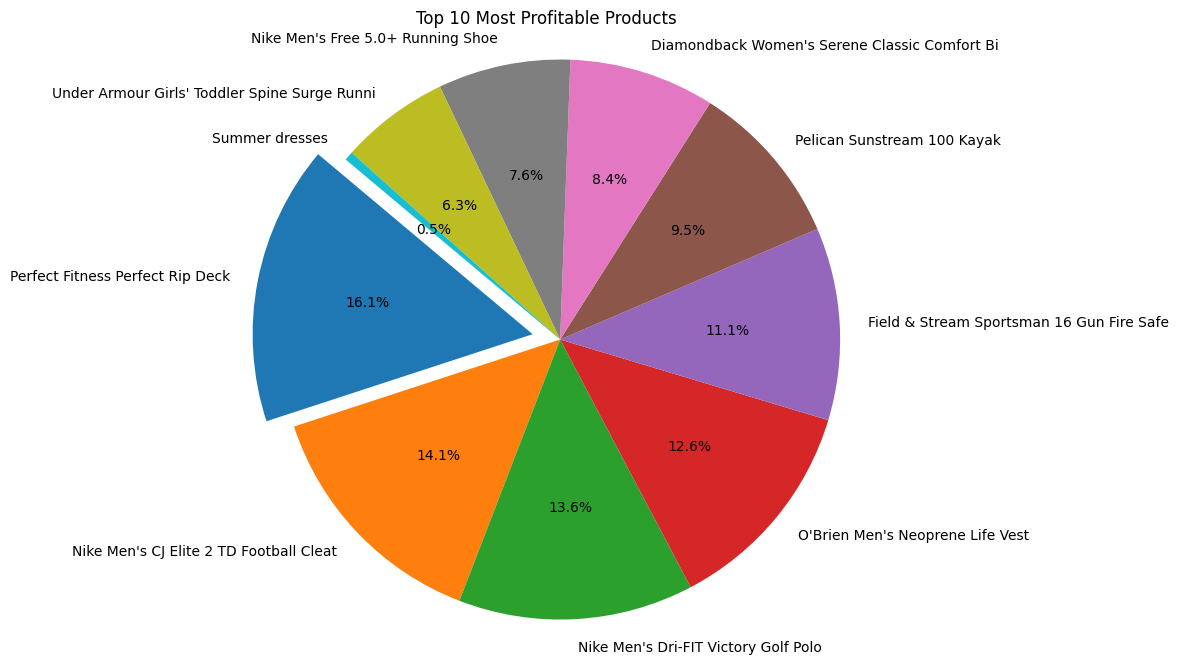

In [ ]:
# Aggregate profit by product name
profit_by_product = df_cleaned.groupBy('Product Name').agg({'Order Item Profit Ratio': 'sum'}).withColumnRenamed('sum(Order Item Profit Ratio)', 'Total Profit')

# Collect data to local Python environment
profit_by_product_local = profit_by_product.toPandas()

# Sort by Total Profit in descending order and select top 10 most profitable products
top_10_profitable_products = profit_by_product_local.sort_values(by='Total Profit', ascending=False).head(10)

# Plot pie chart using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Extract data for pie chart
labels = top_10_profitable_products['Product Name']
sizes = top_10_profitable_products['Total Profit']
explode = (0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0)

plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=140)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Top 10 Most Profitable Products')

plt.show()

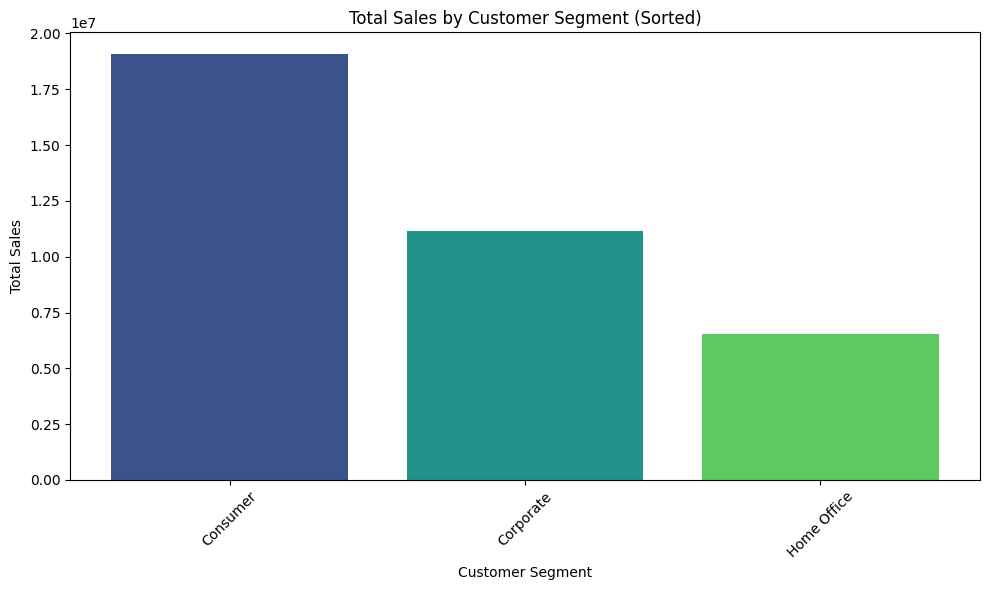

In [ ]:
# Aggregate sales by customer segment
segment_sales = df_cleaned.groupBy('Customer Segment').agg({'Sales': 'sum'}).withColumnRenamed('sum(Sales)', 'Total Sales')

# Collect data to local Python environment and sort by Total Sales
segment_sales_local = segment_sales.toPandas()
segment_sales_local = segment_sales_local.sort_values(by='Total Sales', ascending=False)

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))

# Define colors for bars using a color palette (Seaborn's default palette in this case)
colors = sns.color_palette('viridis', len(segment_sales_local))

plt.bar(segment_sales_local['Customer Segment'], segment_sales_local['Total Sales'], color=colors)

plt.xlabel('Customer Segment')
plt.ylabel('Total Sales')
plt.title('Total Sales by Customer Segment (Sorted)')

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

Correlation matrix:
Row(pearson(features)=DenseMatrix(3, 3, [1.0, 0.1064, 0.7899, 0.1064, 1.0, -0.4762, 0.7899, -0.4762, 1.0], False))


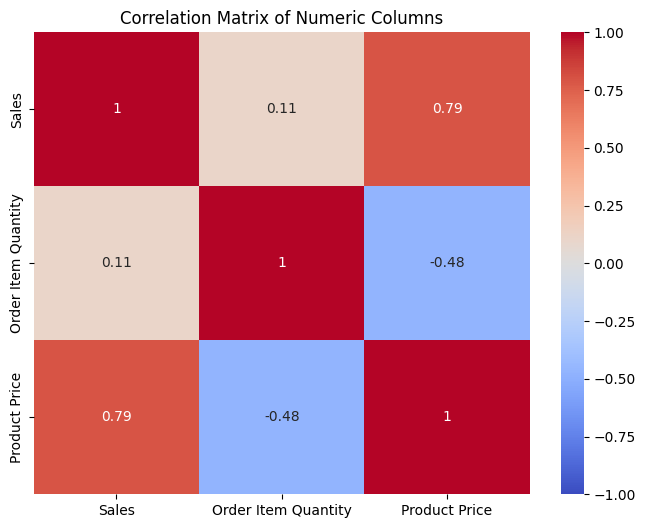

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Select numeric columns for correlation analysis
numeric_cols = ['Sales', 'Order Item Quantity', 'Product Price']

# Assemble numeric columns into a single feature vector
assembler = VectorAssembler(inputCols=numeric_cols, outputCol='features')
df_assembled = assembler.transform(df_cleaned).select('features')

# Compute correlation matrix
correlation_matrix = Correlation.corr(df_assembled, 'features').head()
print("Correlation matrix:")
print(correlation_matrix)

# Extract correlation values from the matrix
corr_values = correlation_matrix[0].toArray()

# Convert correlation matrix to Pandas DataFrame for plotting
df_corr = pd.DataFrame(corr_values, columns=numeric_cols, index=numeric_cols)

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numeric Columns')
plt.show()

+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+---------------+-------------------+------------+-------------+--------------+--------------------------+--------------+-------------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer| Delivery Status|Late_delivery_risk|Category Id| Category Name|Customer City|Customer Country|Customer Id|Customer Segment|Cus

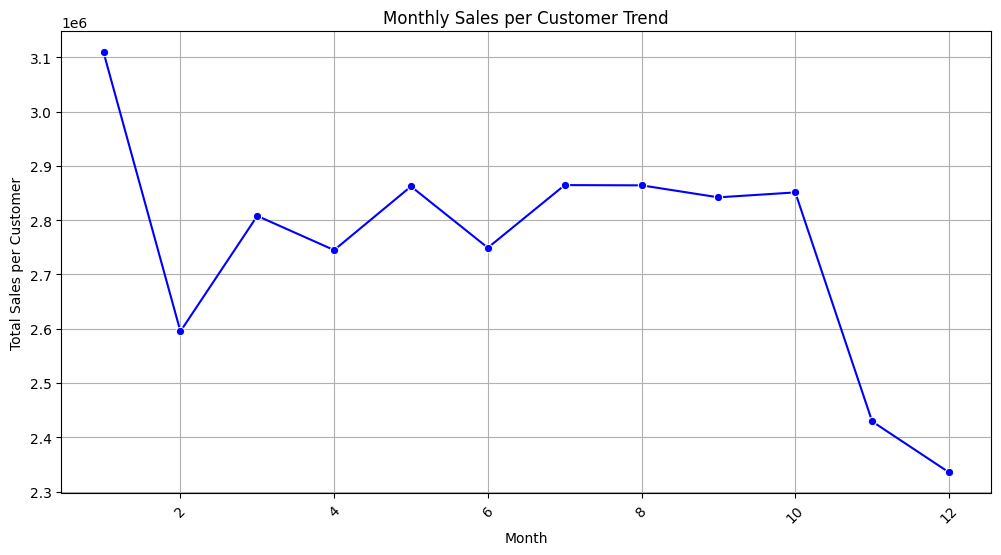

In [ ]:
from pyspark.sql.functions import to_timestamp, month, col, sum
import seaborn as sns
import matplotlib.pyplot as plt

# Set the legacy timeParserPolicy
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Transform the 'order date (DateOrders)' to 'order_date'
df_cleaned = df_cleaned.withColumn('order_date', to_timestamp(col('order date (DateOrders)'), 'M/d/yyyy H:mm'))

# Debugging: Show the transformed DataFrame to check the 'order_date' column
df_cleaned.show(5)

# Group by month and calculate the sum of 'Sales per customer'
monthly_quantity = df_cleaned.groupBy(month('order_date').alias('month')).agg(sum('Sales per customer').alias('total_sales_per_customer')).orderBy('month').toPandas()

# Debugging: Print the grouped data to verify
print(monthly_quantity)

# Plotting the data
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='total_sales_per_customer', data=monthly_quantity, marker='o', color='b')
plt.xlabel('Month')
plt.ylabel('Total Sales per Customer')
plt.title('Monthly Sales per Customer Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()



##From the line chart analysis, it is evident that the highest monthly sales peak occurs in January, whereas December shows the lowest sales. This trend suggests a notable seasonal variation in sales performance throughout the year. January likely benefits from post-holiday shopping and New Year sales promotions, contributing to increased consumer spending. Conversely, December typically experiences lower sales, possibly due to reduced consumer activity after the holiday season and year-end. Understanding these seasonal trends can help businesses strategize their marketing efforts and inventory management to capitalize on peak sales periods while mitigating the impact of slower months.##

In [ ]:
%%html
<div style="background-color: #FFFFE0 ; color: #000000; padding: 20px; border-radius: 10px; text-align: left;">
  <h2> 5. Customer Behavior Analysis  </h2>
</div>

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, month, sum, count, max, datediff, current_date, col, ntile, countDistinct, lag, avg
from pyspark.sql.window import Window

# Convert 'order date (DateOrders)' to a proper date format
df_cleaned = df_cleaned.withColumn('order_date', to_date(col('order date (DateOrders)'), 'M/d/yyyy H:mm'))

# Show the transformed DataFrame
df_cleaned.show(5)


+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+---------------+-------------------+------------+-------------+--------------+--------------------------+--------------+----------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer| Delivery Status|Late_delivery_risk|Category Id| Category Name|Customer City|Customer Country|Customer Id|Customer Segment|Customer Zip

In [ ]:
# Calculate Recency
df_recency = df_cleaned.groupBy('Customer Id').agg(datediff(current_date(), max('order_date')).alias('Recency'))

# Calculate Frequency
df_frequency = df_cleaned.groupBy('Customer Id').agg(count('Order Id').alias('Frequency'))

# Calculate Monetary
df_monetary = df_cleaned.groupBy('Customer Id').agg(sum('Sales').alias('Monetary'))

# Join R, F, and M dataframes
df_rfm = df_recency.join(df_frequency, 'Customer Id').join(df_monetary, 'Customer Id')

# Show the RFM dataframe
df_rfm.show(5)


+-----------+-------+---------+------------------+
|Customer Id|Recency|Frequency|          Monetary|
+-----------+-------+---------+------------------+
|       3997|   2487|       12|2394.6800309000005|
|       6466|   2741|       14|3159.6700744399996|
|        471|   2515|       10|2789.7400551399996|
|      13832|   2437|        1|       357.1000061|
|       6397|   2560|       21|     4605.28007135|
+-----------+-------+---------+------------------+
only showing top 5 rows



##The table reveals customer segments based on Recency, Frequency, and Monetary (RFM) analysis, which are key metrics in understanding customer behavior and value to a business.##

##Customer ID 3997 stands out with the highest frequency (12) and substantial monetary value ($2,394.68), indicating a loyal and high-value customer. This customer has made purchases recently, as indicated by the recency score of 2,487.##

##Similarly, Customer ID 6466 also shows high frequency (14) and monetary value ($3,159.67), suggesting another loyal and valuable customer segment.##

##Conversely, Customer ID 13832 exhibits a low frequency (1) and comparatively low monetary value ($357.10), indicating potentially less engagement with the business.##

##This RFM analysis highlights the importance of segmenting customers based on their purchasing behavior and monetary value. Businesses can use this information to tailor marketing strategies, enhance customer retention efforts, and optimize product offerings to maximize revenue from high-value segments while potentially re-engaging less active segments.##

In [ ]:
from pyspark.sql.window import Window
from pyspark.sql.functions import ntile

# Create a function to score each RFM metric
def rfm_score(df, column, n):
    window_spec = Window.orderBy(col(column).desc())
    return df.withColumn(column + '_score', ntile(n).over(window_spec))

# Apply the scoring function
df_rfm = rfm_score(df_rfm, 'Recency', 5)
df_rfm = rfm_score(df_rfm, 'Frequency', 5)
df_rfm = rfm_score(df_rfm, 'Monetary', 5)

# Calculate the total RFM score
df_rfm = df_rfm.withColumn('RFM_Score', col('Recency_score') + col('Frequency_score') + col('Monetary_score'))

# Show the segmented customers
df_rfm.show(5)


+-----------+-------+---------+------------------+-------------+---------------+--------------+---------+
|Customer Id|Recency|Frequency|          Monetary|Recency_score|Frequency_score|Monetary_score|RFM_Score|
+-----------+-------+---------+------------------+-------------+---------------+--------------+---------+
|        791|   2463|       43|10524.170177599997|            3|              1|             1|        5|
|       9371|   2483|       44|     9299.03020679|            3|              1|             1|        5|
|       8766|   2470|       38|     9296.14018638|            3|              1|             1|        5|
|       1657|   2574|       42| 9223.710151749998|            2|              1|             1|        4|
|       2641|   2513|       43| 9130.920223579998|            3|              1|             1|        5|
+-----------+-------+---------+------------------+-------------+---------------+--------------+---------+
only showing top 5 rows



In [ ]:
# Average Purchase Value
df_avg_purchase = df_cleaned.groupBy('Customer Id').agg((sum('Sales') / countDistinct('Order Id')).alias('AvgPurchaseValue'))

# Purchase Frequency
df_purchase_freq = df_cleaned.groupBy('Customer Id').agg(countDistinct('Order Id').alias('PurchaseFrequency'))

# Join Avg Purchase Value and Purchase Frequency
df_clv = df_avg_purchase.join(df_purchase_freq, 'Customer Id')

# Show the CLV DataFrame
df_clv.show(5)


+-----------+-----------------+-----------------+
|Customer Id| AvgPurchaseValue|PurchaseFrequency|
+-----------+-----------------+-----------------+
|       2142|657.4450092499999|                4|
|      11317|    524.954014222|                5|
|      10362|    677.944017796|                5|
|       4935|    579.314009498|                5|
|       3997|    598.670007725|                4|
+-----------+-----------------+-----------------+
only showing top 5 rows



##Customer IDs 2142, 11317, 10362, 4935, and 3997 showcase distinctive purchasing patterns characterized by a higher average purchase value and moderate to frequent purchase frequencies. These segments are indicative of loyal customers who contribute significantly to revenue generation. Their consistent engagement underscores the potential for tailored marketing initiatives aimed at enhancing customer satisfaction and maximizing lifetime value.##

In [ ]:
lifespan_years = 1

# Calculate CLV
df_clv = df_clv.withColumn('CLV', col('AvgPurchaseValue') * col('PurchaseFrequency') * lifespan_years)

# Show the CLV DataFrame
df_clv.show(5)


+-----------+-----------------+-----------------+------------------+
|Customer Id| AvgPurchaseValue|PurchaseFrequency|               CLV|
+-----------+-----------------+-----------------+------------------+
|       2142|657.4450092499999|                4|2629.7800369999995|
|      11317|    524.954014222|                5|2624.7700711099997|
|      10362|    677.944017796|                5|     3389.72008898|
|       4935|    579.314009498|                5|     2896.57004749|
|       3997|    598.670007725|                4|      2394.6800309|
+-----------+-----------------+-----------------+------------------+
only showing top 5 rows



##Customer Lifetime Value (CLV) is a metric that represents the total revenue a business can reasonably expect from a single customer account over the entire relationship with that customer. It helps businesses understand the value each customer brings over their lifetime and informs decisions related to customer acquisition, retention, and marketing strategies.##
##The CLV analysis reveals varying levels of customer value based on average purchase value and purchase frequency. Customers like those with ID 10362 show higher potential CLV, indicating they are valuable assets for long-term revenue generation. This insight underscores the importance of nurturing relationships with high CLV customers while also focusing on increasing engagement and retention strategies for others to maximize overall business profitability.##







In [ ]:
# Calculate the days between purchases for each customer
window_spec = Window.partitionBy('Customer Id').orderBy('order_date')
df_lag = df_cleaned.withColumn('PrevOrderDate', lag('order_date').over(window_spec))
df_interval = df_lag.withColumn('PurchaseInterval', datediff(col('order_date'), col('PrevOrderDate')))

# Show the Purchase Interval DataFrame
df_interval.show(5)


+-----+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+----------------+-------------+----------------+-----------+----------------+----------------+-------------+---------------+-----------+------------+------------+-------------+--------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+-----------+----------------+----------------------+------------+-----------------+------------+---------------+-------------------+--------------------+-------------+--------------+--------------------------+--------------+-------------------+-------------------+----------------+
| Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer| Delivery Status|Late_delivery_risk|Category Id|   Category Name|Customer City|

In [ ]:
# Calculate average purchase interval
df_avg_interval = df_interval.groupBy('Customer Id').agg(avg('PurchaseInterval').alias('AvgPurchaseInterval'))

# Show the average purchase interval DataFrame
df_avg_interval.show(5)


+-----------+-------------------+
|Customer Id|AvgPurchaseInterval|
+-----------+-------------------+
|          1|               NULL|
|          2|  85.44444444444444|
|          3| 32.470588235294116|
|          4|  47.30769230769231|
|          5| 22.833333333333332|
+-----------+-------------------+
only showing top 5 rows



In [ ]:
# Define a churn threshold in days
churn_threshold = 90

# Identify customers who haven't purchased within the churn threshold
df_churn = df_recency.withColumn('AtRiskOfChurn', col('Recency') > churn_threshold)

# Show the churn risk DataFrame
df_churn.show(5)


+-----------+-------+-------------+
|Customer Id|Recency|AtRiskOfChurn|
+-----------+-------+-------------+
|       3997|   2487|         true|
|       6466|   2741|         true|
|        471|   2515|         true|
|      13832|   2437|         true|
|       6397|   2560|         true|
+-----------+-------+-------------+
only showing top 5 rows



In [ ]:
%%html
<div style="background-color: #FFFFE0 ; color: #000000; padding: 20px; border-radius: 10px; text-align: left;">
  <h2> 6. Delivery Performance Analysis  </h2>
</div>

In [ ]:
# Convert shipping and order dates to date format if not already done
from pyspark.sql.functions import to_date

df_cleaned = df_cleaned.withColumn('order_date', to_date(col('order date (DateOrders)'), 'M/d/yyyy H:mm'))
df_cleaned = df_cleaned.withColumn('shipping_date', to_date(col('shipping date (DateOrders)'), 'M/d/yyyy H:mm'))

# Calculate actual delivery time
df_delivery_time = df_cleaned.withColumn('DeliveryTime', datediff(col('shipping_date'), col('order_date')))

# Show the DataFrame with delivery time
df_delivery_time.show(5)


+--------+------------------------+-----------------------------+-----------------+------------------+----------------+------------------+-----------+--------------+-------------+----------------+-----------+----------------+----------------+-------------+---------------+-----------+------------+------------+----------+-------------+-----------------+-----------------------+--------+----------------------+-------------------+------------------------+-------------+------------------------+-----------------------+-------------------+------+----------------+----------------------+--------------+---------------+---------------+---------------+-------------------+------------+-------------+--------------+--------------------------+--------------+----------+-------------+------------+
|    Type|Days for shipping (real)|Days for shipment (scheduled)|Benefit per order|Sales per customer| Delivery Status|Late_delivery_risk|Category Id| Category Name|Customer City|Customer Country|Customer Id|Cu

In [ ]:
# Calculate average delivery time by shipping mode
avg_delivery_time_by_mode = df_delivery_time.groupBy('Shipping Mode').agg(avg('DeliveryTime').alias('AvgDeliveryTime'))

# Show the average delivery time by shipping mode
avg_delivery_time_by_mode.show()


+--------------+------------------+
| Shipping Mode|   AvgDeliveryTime|
+--------------+------------------+
|   First Class|               2.0|
|      Same Day|0.4782787306151792|
|  Second Class|3.9908280327124035|
|Standard Class| 3.995907268542579|
+--------------+------------------+



##we can see significant variations in average delivery times based on shipping modes. "Same Day" shipping stands out with the shortest average delivery time, approximately 0.48 days, highlighting its efficiency in quick order fulfillment. In contrast, "Standard Class" and "Second Class" shipping modes have longer average delivery times, around 4 days each. These insights are crucial for optimizing logistics and managing customer expectations based on shipping preferences.##

In [ ]:
# Calculate the count of late deliveries
late_deliveries = df_cleaned.groupBy('Late_delivery_risk').agg(count('Order Id').alias('Count'))

# Show the late delivery instances
late_deliveries.show()


+------------------+-----+
|Late_delivery_risk|Count|
+------------------+-----+
|                 1|98977|
|                 0|81542|
+------------------+-----+



In [ ]:
# Calculate late delivery risk by shipping mode
late_delivery_risk_by_mode = df_cleaned.groupBy('Shipping Mode').agg(
    sum(when(col('Late_delivery_risk') == 1, 1).otherwise(0)).alias('LateDeliveries'),
    count('Order Id').alias('TotalDeliveries')
).withColumn('LateDeliveryRisk', col('LateDeliveries') / col('TotalDeliveries'))

# Show late delivery risk by shipping mode
late_delivery_risk_by_mode.show()


+--------------+--------------+---------------+-------------------+
| Shipping Mode|LateDeliveries|TotalDeliveries|   LateDeliveryRisk|
+--------------+--------------+---------------+-------------------+
|   First Class|         26513|          27814| 0.9532249946070325|
|      Same Day|          4454|           9737| 0.4574304200472425|
|  Second Class|         26987|          35216|  0.766327805542935|
|Standard Class|         41023|         107752|0.38071683124211153|
+--------------+--------------+---------------+-------------------+



##This table highlights significant differences in late delivery risks across various shipping modes. "First Class" shipping has the highest late delivery risk at approximately 95.32%, indicating a substantial reliability issue despite its intended premium service level. "Second Class" follows with a 76.63% late delivery risk, suggesting significant delays as well. "Same Day" shipping shows a moderate late delivery risk of about 45.74%, performing better in comparison but still facing delays. "Standard Class" shipping has the lowest late delivery risk at approximately 38.07%, showing the most reliable performance among the evaluated shipping modes. This information is essential for logistics planning and customer satisfaction strategies, pointing out areas where improvements are necessary.##

<ipython-input-45-8f709c8e4618>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Shipping Mode', y='AvgDeliveryTime', data=avg_delivery_time_by_mode_pd, palette='viridis')


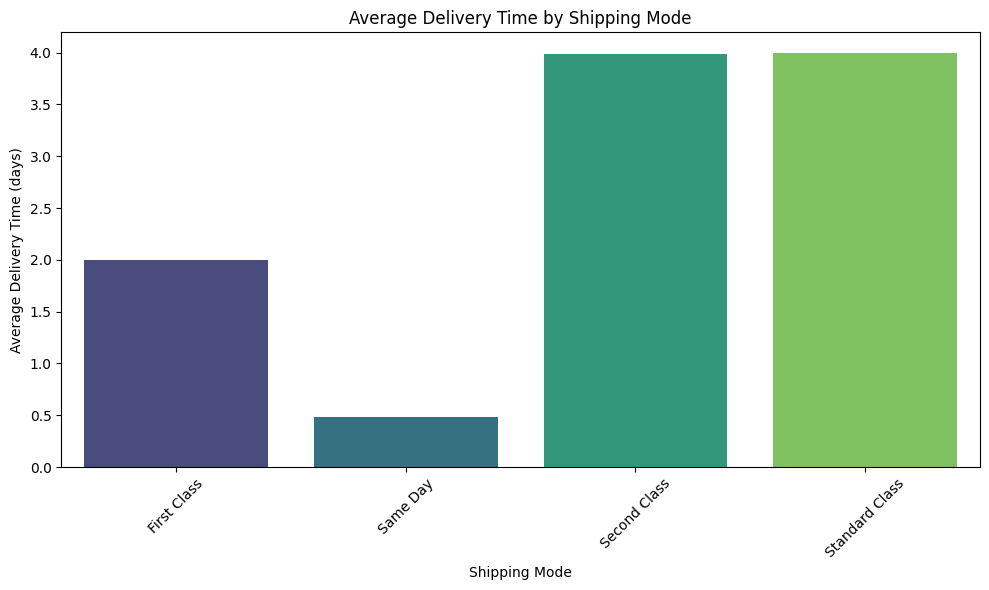

In [ ]:
# Convert to Pandas DataFrame for visualization
avg_delivery_time_by_mode_pd = avg_delivery_time_by_mode.toPandas()

# Plotting with Matplotlib and Seaborn
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='Shipping Mode', y='AvgDeliveryTime', data=avg_delivery_time_by_mode_pd, palette='viridis')
plt.xlabel('Shipping Mode')
plt.ylabel('Average Delivery Time (days)')
plt.title('Average Delivery Time by Shipping Mode')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-46-1324d9875bbf>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Shipping Mode', y='LateDeliveryRisk', data=late_delivery_risk_by_mode_pd, palette='magma')


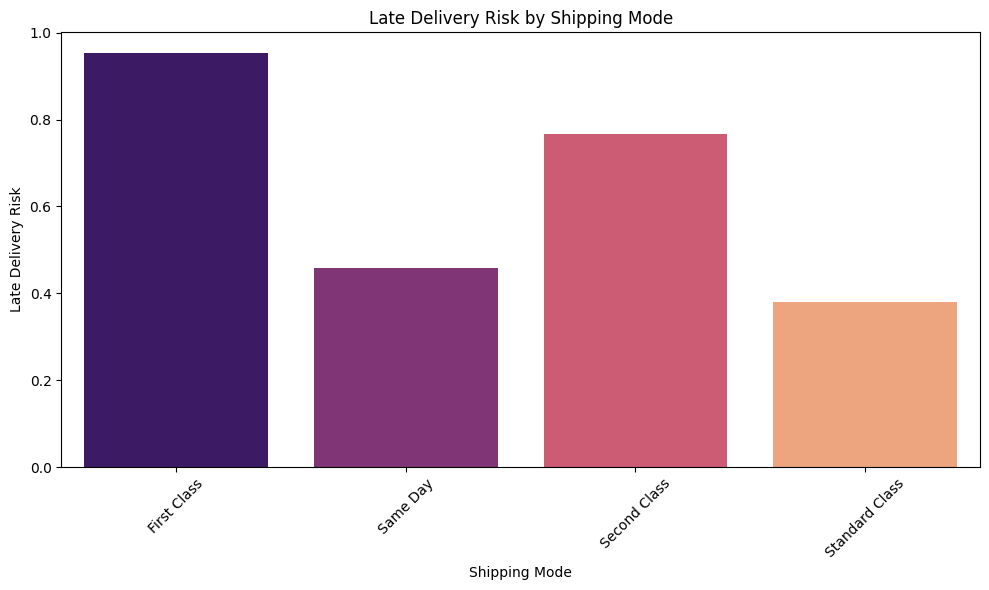

In [ ]:
# Convert to Pandas DataFrame for visualization
late_delivery_risk_by_mode_pd = late_delivery_risk_by_mode.toPandas()

# Plotting with Matplotlib and Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Shipping Mode', y='LateDeliveryRisk', data=late_delivery_risk_by_mode_pd, palette='magma')
plt.xlabel('Shipping Mode')
plt.ylabel('Late Delivery Risk')
plt.title('Late Delivery Risk by Shipping Mode')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
from pyspark.sql.functions import to_timestamp, datediff, col, avg, sum, count, when

# Convert date columns to timestamp
df_cleaned = df_cleaned.withColumn('order_date', to_timestamp(col('order date (DateOrders)'), 'M/d/yyyy H:mm'))
df_cleaned = df_cleaned.withColumn('shipping_date', to_timestamp(col('shipping date (DateOrders)'), 'M/d/yyyy H:mm'))

# Calculate delivery time in days
df_cleaned = df_cleaned.withColumn('DeliveryTime', datediff(col('shipping_date'), col('order_date')))

# Debugging: Show the schema and a sample of the dataframe
df_cleaned.printSchema()
df_cleaned.show(5)

# Check if the required columns are present
required_columns = ['Shipping Mode', 'Late_delivery_risk', 'Order Id', 'DeliveryTime']
missing_columns = [col for col in required_columns if col not in df_cleaned.columns]
if missing_columns:
    print(f"Missing columns: {missing_columns}")
else:
    print("All required columns are present.")

# Calculate delivery metrics
delivery_metrics = df_cleaned.groupBy('Shipping Mode').agg(
    avg('DeliveryTime').alias('AvgDeliveryTime'),
    sum(when(col('Late_delivery_risk') == 1, 1).otherwise(0)).alias('LateDeliveries'),
    count('Order Id').alias('TotalDeliveries')
).withColumn('LateDeliveryRisk', col('LateDeliveries') / col('TotalDeliveries'))

# Show the delivery metrics
delivery_metrics.show()


root
 |-- Type: string (nullable = true)
 |-- Days for shipping (real): integer (nullable = true)
 |-- Days for shipment (scheduled): integer (nullable = true)
 |-- Benefit per order: double (nullable = true)
 |-- Sales per customer: double (nullable = true)
 |-- Delivery Status: string (nullable = true)
 |-- Late_delivery_risk: integer (nullable = true)
 |-- Category Id: integer (nullable = true)
 |-- Category Name: string (nullable = true)
 |-- Customer City: string (nullable = true)
 |-- Customer Country: string (nullable = true)
 |-- Customer Id: integer (nullable = true)
 |-- Customer Segment: string (nullable = true)
 |-- Customer Zipcode: integer (nullable = true)
 |-- Department Id: integer (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Market: string (nullable = true)
 |-- Order City: string (nullable = true)
 |-- Order Country: string (nullable = true)
 |-- Order Customer I

##The comprehensive analysis of sales, customer behavior, and delivery performance provides valuable insights into the current state of the business. Key findings indicate significant sales variations across product categories, with certain areas demonstrating strong performance while others present opportunities for growth. Customer behavior metrics, including recency, frequency, and monetary value, highlight the importance of targeting engaged and high-value customers to maximize Customer Lifetime Value (CLV). Delivery performance analysis underscores the need to address late delivery risks and optimize shipping methods to enhance reliability and customer satisfaction. Overall, these insights can guide strategic decisions to improve sales, customer retention, and operational efficiency.##